In [69]:
%matplotlib inline

# Laden der verwendeten Bibliotheken
import   numpy  as np   
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import cv2

In [70]:
def imshow(img):
    shape=img.shape
    plt.figure(figsize = (10,10))
    if(len(shape)==2):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis(False)
    plt.show()   

In [71]:
def fullContrast(img):
    min=np.min(img)
    max=np.max(img)
    return (img-min).astype(float)/(max-min)

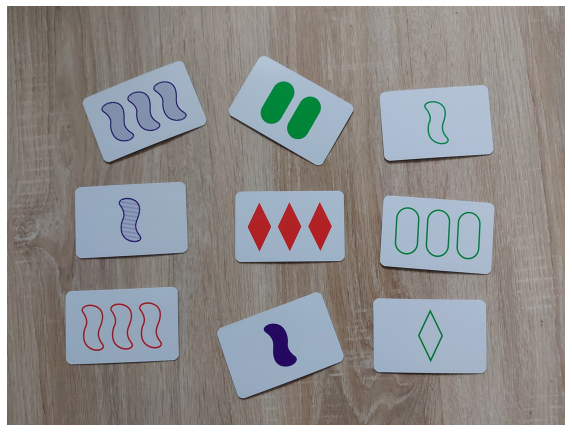

In [72]:
# Bild laden mit OpenCV
img = cv2.imread("set/set1.jpg")
imshow(img)

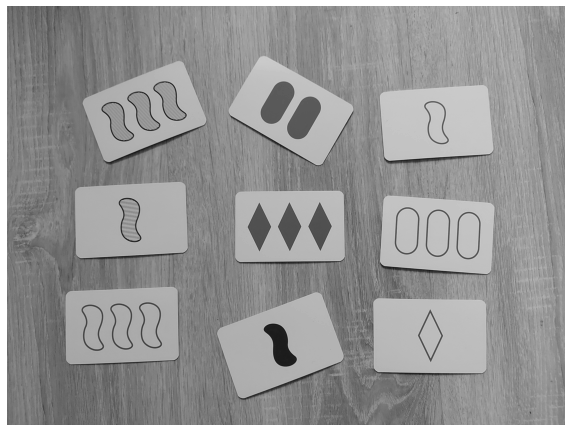

In [73]:
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

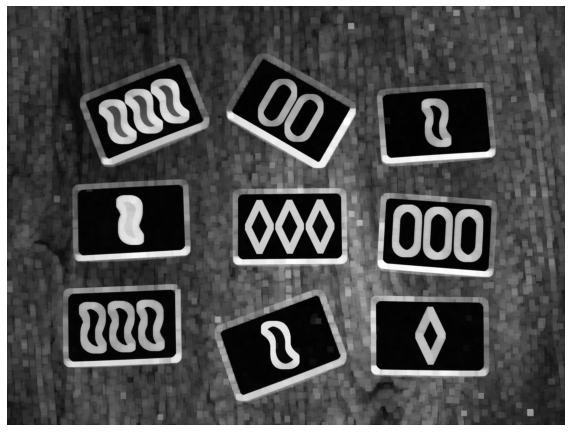

In [74]:
morphgradient=cv2.dilate(gray,np.ones((23,23)))-cv2.erode(gray,np.ones((23,23)))
imshow(morphgradient)

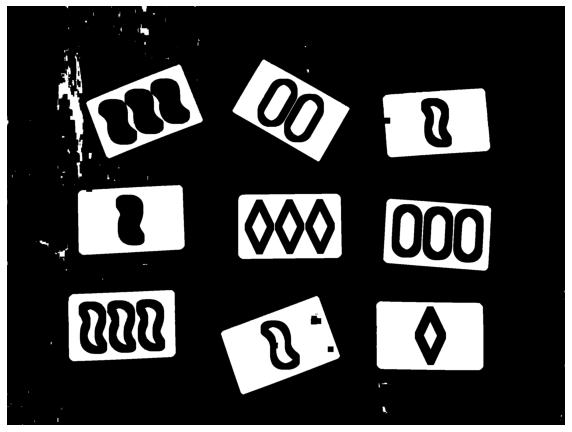

In [75]:
regions=(morphgradient<20).astype(np.uint8)
imshow(fullContrast(regions))

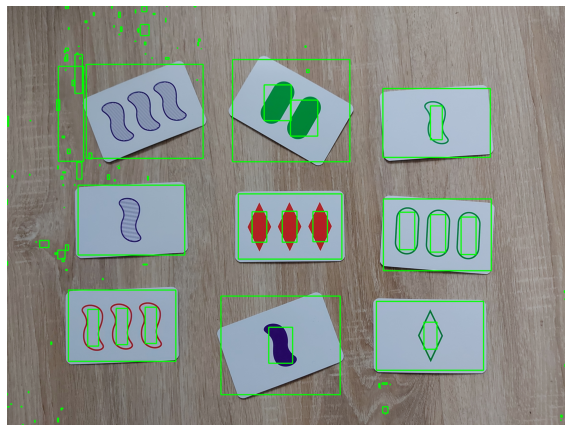

In [76]:
(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(regions, 4, cv2.CV_32S)
boundingboxview=img.copy()
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(boundingboxview,(x,y),(x+w,y+h),(0,255,0),3)
    mask=(labels==i).astype(np.uint8)
imshow(boundingboxview)

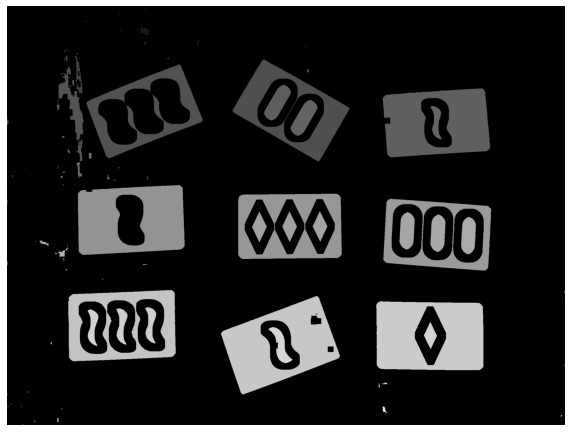

In [77]:
imshow(labels)

In [78]:
# Extrahieren aller äußeren Konturen als Liste von Pixelketten
contours,_ = cv2.findContours(regions,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))

109


In [79]:
contour=contours[62]
print(contour.shape)
print(contour)

(85, 1, 2)
[[[  0 456]]

 [[  0 457]]

 [[  0 458]]

 [[  0 459]]

 [[  0 460]]

 [[  0 461]]

 [[  0 462]]

 [[  0 463]]

 [[  0 464]]

 [[  0 465]]

 [[  0 466]]

 [[  0 467]]

 [[  0 468]]

 [[  0 469]]

 [[  0 470]]

 [[  0 471]]

 [[  0 472]]

 [[  0 473]]

 [[  0 474]]

 [[  0 475]]

 [[  0 476]]

 [[  0 477]]

 [[  0 478]]

 [[  0 479]]

 [[  0 480]]

 [[  0 481]]

 [[  0 482]]

 [[  0 483]]

 [[  0 484]]

 [[  0 485]]

 [[  0 486]]

 [[  0 487]]

 [[  0 488]]

 [[  0 489]]

 [[  0 490]]

 [[  0 491]]

 [[  0 492]]

 [[  0 493]]

 [[  0 494]]

 [[  0 495]]

 [[  0 496]]

 [[  0 495]]

 [[  0 494]]

 [[  0 493]]

 [[  0 492]]

 [[  0 491]]

 [[  1 490]]

 [[  1 489]]

 [[  1 488]]

 [[  1 487]]

 [[  2 486]]

 [[  3 486]]

 [[  4 486]]

 [[  4 485]]

 [[  4 484]]

 [[  5 483]]

 [[  5 482]]

 [[  5 481]]

 [[  5 480]]

 [[  5 479]]

 [[  5 478]]

 [[  5 477]]

 [[  5 476]]

 [[  5 475]]

 [[  5 474]]

 [[  4 474]]

 [[  3 474]]

 [[  2 474]]

 [[  1 473]]

 [[  1 472]]

 [[  0 47

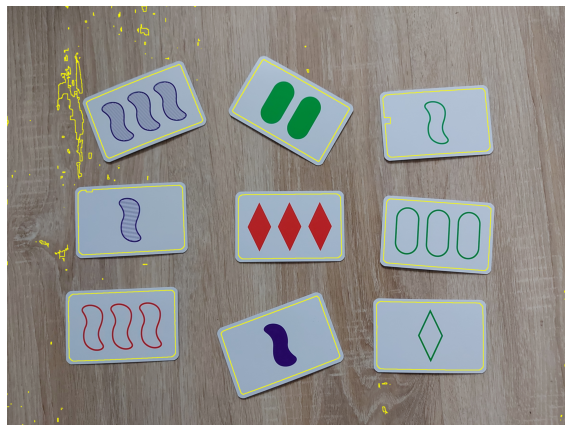

In [80]:
annotated=img.copy()

for contour in contours: 
    cv2.drawContours(annotated, [contour], 0, (0,255,255), 2)
    
imshow(annotated)

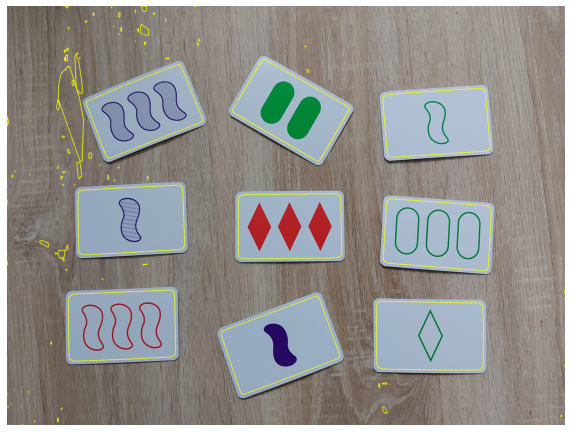

In [81]:
annotated=img.copy()

for contour in contours:
    
    convex=cv2.convexHull(contour) 

    cv2.drawContours(annotated, [convex], 0, (0,255,255), 2)

imshow(annotated)

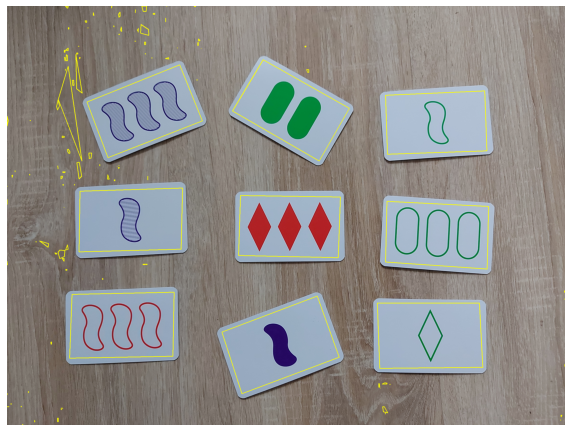

In [82]:
annotated=img.copy()

for contour in contours:
    convex=cv2.convexHull(contour) 

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    cv2.drawContours(annotated, [approx], 0, (0,255,255), 2)
imshow(annotated)

In [83]:
# Liste zum Speichern der Rechtecke zu den gefundenen Karten
card_quadrangles=[]


for contour in contours:

    convex=cv2.convexHull(contour) # Konvexe Hülle bilden

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    if(len(approx)!=4): # Viereckstest
        continue
        
    # Alle vier Kantenlängen ermitteln. "cv2.norm" berechnet per Default die L2-Norm, also den Euklidischen Abstand
    l0=cv2.norm(approx[0],approx[1]) 
    l1=cv2.norm(approx[1],approx[2])
    l2=cv2.norm(approx[2],approx[3])
    l3=cv2.norm(approx[3],approx[0])
    
    # Mittlere Breite und Höhe bestimmen (Annahme: Parallelogramm)
    w,h = (l0+l2)/2, (l1+l3)/2
    
    if(abs(l0-l2)>0.15*w) | (abs(l1-l3)>0.15*h): # Parallelogrammtest
        continue
    
    # Wenn Breite>Höhe: um 90° drehen (eine Karte ist höher als breit)
    if(w>h):
        w,h = h,w
        approx=np.roll(approx,1,axis=0)

    if(w  <100) | (h > 600): # Größentest
        continue

    if(h > 2.2*w) | (h<1.2 * w):   # Seitenverhältnistest
        continue

    card_quadrangles.append(np.squeeze(approx))

print(len(card_quadrangles))

9


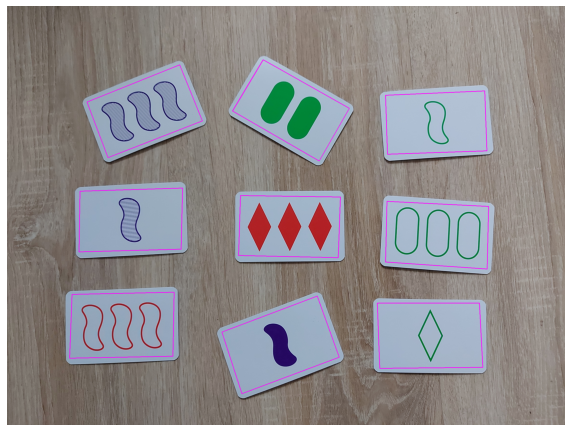

In [84]:
annotated=img.copy()
for quad in card_quadrangles:
    cv2.drawContours(annotated, [quad], 0, (255,0,255), 2)
imshow(annotated)

473.0282791852951
[[[254 256]]

 [[146 304]]

 [[ 44 246]]

 [[152 199]]]
548.4742395877838
[[[ 27 246]]

 [[151 190]]

 [[271 257]]

 [[145 312]]]


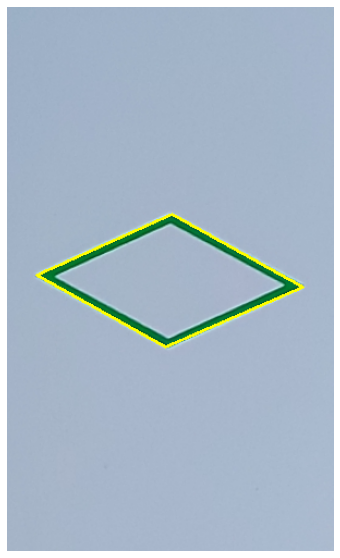

The number of objects in this image:  0
12.796691417694092
[[[163 293]]

 [[157 291]]]
4.0
[[[170 213]]

 [[168 213]]]
8.398345708847046
[[[164 211]]

 [[160 210]]

 [[162 210]]]
559.8172676563263
[[[256 214]]

 [[223 295]]

 [[ 46 288]]

 [[ 84 207]]]


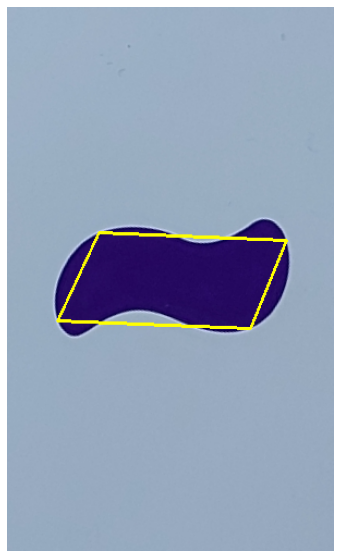

The number of objects in this image:  0
571.098458647728
[[[266 349]]

 [[230 432]]

 [[ 53 431]]

 [[ 85 348]]]
570.4806413650513
[[[262 206]]

 [[228 291]]

 [[ 52 294]]

 [[ 83 207]]]
569.5702426433563
[[[259  67]]

 [[222 152]]

 [[ 50 155]]

 [[ 81  66]]]


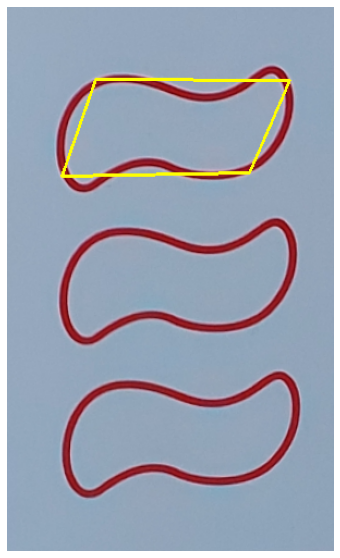

The number of objects in this image:  0
586.978336930275
[[[ 41 392]]

 [[ 87 350]]

 [[220 353]]

 [[269 418]]

 [[225 463]]

 [[ 93 461]]]
596.2151138782501
[[[ 42 245]]

 [[ 85 200]]

 [[219 202]]

 [[273 267]]

 [[232 315]]

 [[ 99 314]]]
603.0816004276276
[[[ 44  92]]

 [[ 88  45]]

 [[227  48]]

 [[276 117]]

 [[236 163]]

 [[101 162]]]


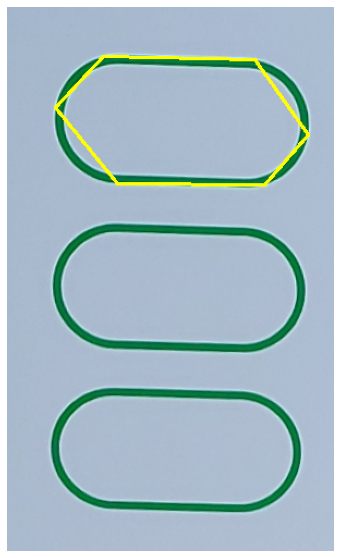

The number of objects in this image:  0
548.9965846538544
[[[279 394]]

 [[159 458]]

 [[ 33 405]]

 [[152 340]]]
510.88470351696014
[[[272 243]]

 [[154 306]]

 [[ 30 254]]]
510.6687364578247
[[[272 241]]

 [[ 30 252]]

 [[148 189]]]
510.38495445251465
[[[268  91]]

 [[150 154]]

 [[ 26 103]]]
508.67874109745026
[[[268  89]]

 [[ 27 101]]

 [[143  38]]]


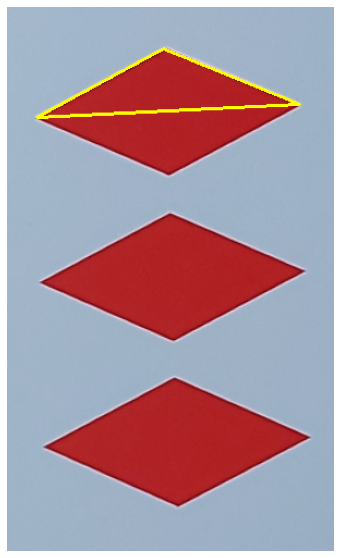

The number of objects in this image:  0
571.4929393529892
[[[256 207]]

 [[215 293]]

 [[ 42 289]]

 [[ 75 208]]]


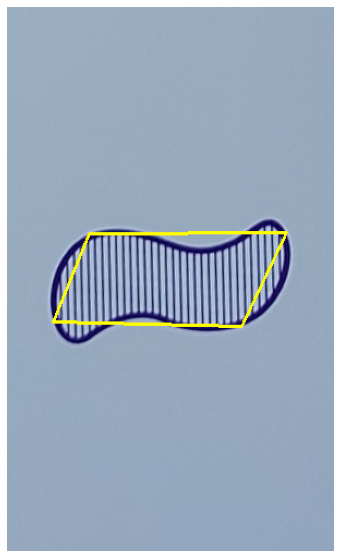

The number of objects in this image:  0
576.0215820074081
[[[256 199]]

 [[215 288]]

 [[ 44 290]]

 [[ 75 202]]]


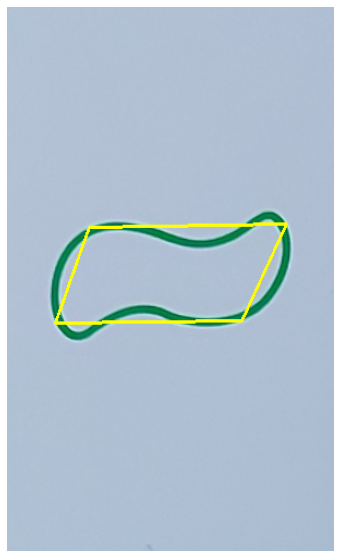

The number of objects in this image:  0
563.0366816520691
[[[257 353]]

 [[216 435]]

 [[ 46 425]]

 [[ 80 343]]]
561.7696295976639
[[[256 211]]

 [[218 293]]

 [[ 48 292]]

 [[ 80 203]]]
558.9059405326843
[[[256  70]]

 [[215 155]]

 [[ 48 150]]

 [[ 81  65]]]


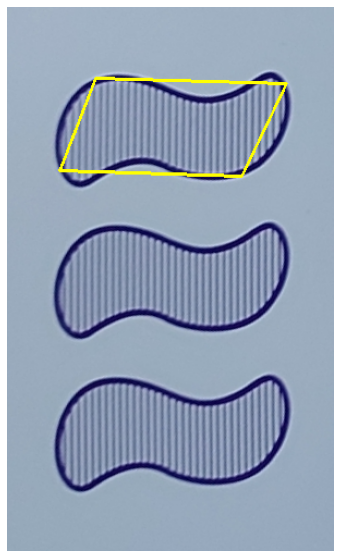

The number of objects in this image:  0
583.6459574699402
[[[262 324]]

 [[211 383]]

 [[ 73 381]]

 [[ 33 330]]

 [[ 84 273]]

 [[220 274]]]
585.2167077064514
[[[262 165]]

 [[206 230]]

 [[ 73 228]]

 [[ 34 182]]

 [[ 85 119]]

 [[221 120]]]


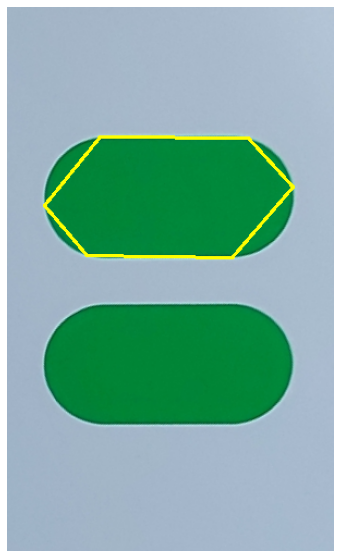

The number of objects in this image:  0


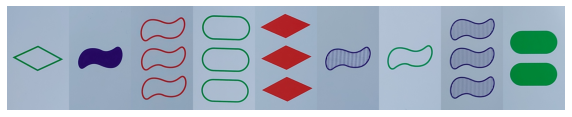

In [95]:
result = None

card_images = dict()

for card in card_quadrangles:
    
    destRect = np.float32([[0,0],[300,0],[300,500],[0,500]])

    transformMatrix = cv2.getPerspectiveTransform(card.astype(np.float32), destRect)

    cardImage = cv2.warpPerspective(img,transformMatrix,(300,500))
    
    gray= cv2.cvtColor(cardImage,cv2.COLOR_BGR2GRAY)

    edges= cv2.Canny(gray, 50,200)

    contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    annotated = cardImage.copy()

    numOfObj = 0

    for contour in contours:
        convex=cv2.convexHull(contour) 
        arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
        print(arcLength)
        approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen
        print(approx)
        if(len(approx)!=4): # Viereckstest
            continue
        
        # Alle vier Kantenlängen ermitteln. "cv2.norm" berechnet per Default die L2-Norm, also den Euklidischen Abstand
        l0=cv2.norm(approx[0],approx[1]) 
        l1=cv2.norm(approx[1],approx[2])
        l2=cv2.norm(approx[2],approx[3])
        l3=cv2.norm(approx[3],approx[0])
        
        # Mittlere Breite und Höhe bestimmen (Annahme: Parallelogramm)
        w,h = (l0+l2)/2, (l1+l3)/2
        
        if(abs(l0-l2)>0.15*w) | (abs(l1-l3)>0.15*h): # Parallelogrammtest
            continue
        
        # Wenn Breite>Höhe: um 90° drehen (eine Karte ist höher als breit)
        if(w>h):
            w,h = h,w
            approx=np.roll(approx,1,axis=0)

        if(w  <100) | (h > 400): # Größentest
            continue

        if(h > 2.2*w) | (h<1.2 * w):   # Seitenverhältnistest
            continue

        numOfObj += 1

    cv2.drawContours(annotated, [approx], 0, (0,255,255), 2)
    imshow(annotated)

    print ("The number of objects in this image: ", str(numOfObj))

    if result is None:
        result=cardImage.copy()
    else:
        result=np.concatenate([result,cardImage],axis=1)   

imshow(result)